# Skill assessment - eventwise
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 13-02-2023<br>


**Introduction**:<br>


**Questions**:<br>
* [x] Weighting the model average by the Brier score?
* [ ] Take into account the model spread?
* [ ] Sort stations by catchment area (or other order)?
* [ ] Persistence

**Tasks to do**:<br>
* What's `pred_event` for?

**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## 1 Data

In [2]:
name = 'global'
folders = os.listdir('results/')

In [3]:
# path where results will be saved
path_out = f'results/skill/{name}/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [4]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

### 1.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations_loop.ipynb).

In [5]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'results/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# add columns where skill will be saved
new_cols = [f'f1_{model}' for model in ['current', 'model_mean', 'member_weighted']]
stations[new_cols] = np.nan

no. stations:			1039


In [6]:
# shapefile with rivers
rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')
mask = rivers_shp.BASIN.isin(catchments)
rivers_shp = rivers_shp.loc[mask]

### 1.2 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In this [notebook](2_2_reanalysis_preprocessing.ipynb) the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

In [7]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
#start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 1, 6) + timedelta(hours=39*6)
start, end = datetime(2021, 1, 1, 6), datetime(2022, 1, 10, 12)
rean_exc = rean_exc.loc[start:end, stations.index.tolist()]

In [8]:
# # load probability of exceeding the discharge threshold in the REANALYSIS data
# rean_onsets = pd.read_parquet(f'{path_reanalysis}/events_rl5.parquet')
# rean_onsets.columns = rean_onsets.columns.astype(int)
# rean_onsets = rean_onsets.loc[start:end, stations.index.tolist()]
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

In [9]:
# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))

no. events:			392


In [10]:
# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))
# stations = stations.loc[mask_stn,:]
# rean_exc = rean_exc.loc[:,mask_stn]
# rean_onsets = rean_onsets.loc[:,mask_stn]
# print('no. stations with events:\t{0}'.format(stations.shape[0]))

no. stations with events:	275


In [102]:
stations.X

station_id
2184    4407500.0
2020    4462500.0
2021    3462500.0
3219    3432500.0
3221    3432500.0
          ...    
2012    3452500.0
1575    3727500.0
1685    6652500.0
2490    6517500.0
1368    3597500.0
Name: X, Length: 1039, dtype: float64

In [114]:
rean_onsets.sum()

station_id
2184    1
2020    0
2021    2
3219    1
3221    1
       ..
2012    0
1575    0
1685    2
2490    0
1368    0
Length: 1039, dtype: int64

In [121]:
import matplotlib as mpl

In [130]:
# colormap used for the maps
cmap = plt.cm.coolwarm
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('no. events', cmaplist, cmap.N)
bounds = np.arange(1, 7, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

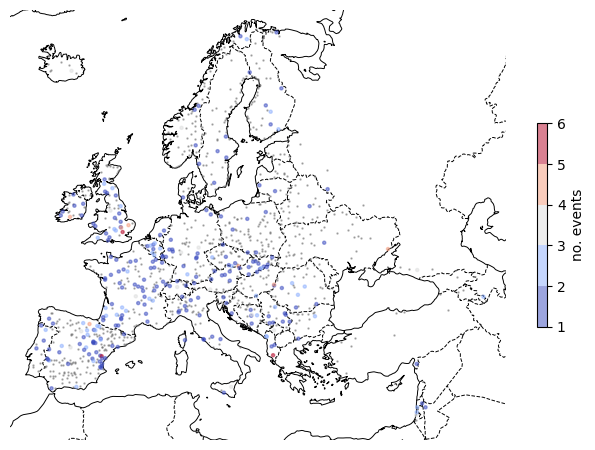

In [131]:
plot_map_stations(stations.X, stations.Y, rean_onsets.sum(), mask=~mask_stn,
                  cmap=cmap, norm=norm, size=5, figsize=(8, 8))
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events');

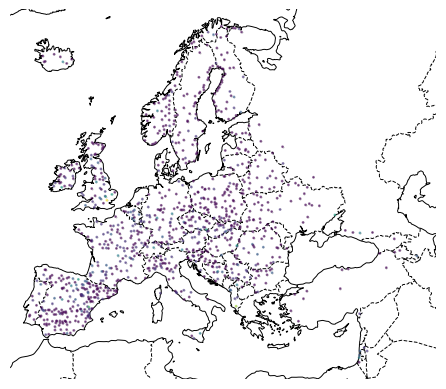

In [105]:
plot_map_f1(stations.X, stations.Y, rean_onsets.sum(), mask=mask_stn, s=8)

### 1.3 Exceedance forecast

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [11]:
# models
models = {'COS': {'members': 20, 'leadtimes': 23},
          'DWD': {'members': 1, 'leadtimes': 29},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}

min_leadtime = min([models[m]['leadtimes'] for m in models])

In [12]:
# load probability of exceeding the discharge threshold in the FORECAST data
path_forecast = '../data/exceedance/forecast/'

fore_exc = {}
for stn in stations.index:
    da = xr.open_dataarray(f'{path_forecast}{stn:04d}.nc')
    if 'id' in da.coords:
        da = da.drop_vars('id')
    fore_exc[stn] = da
    da.close()

# convert into a Dataset
stn = stations.index[0]
fore_exc = xr.Dataset(fore_exc, coords={'model': fore_exc[stn].model,
                                        'forecast': fore_exc[stn].forecast,
                                        'leadtime': fore_exc[stn].leadtime})

In [13]:
# DataArray with weights for each model and leadtime
weights = np.zeros((len(fore_exc.model), len(fore_exc.leadtime)))
for i, (key, value) in enumerate(models.items()):
    leadtimes = value['leadtimes']
    members = value['members']
    weights[i,:leadtimes] = members
weights = xr.DataArray(weights, coords={'model': list(models), 'leadtime': fore_exc.leadtime})

## 2 Compute events

In this section I will create two boolean _DataArray_ with the onset of flood events, i.e., a matrix of zeros and ones where a one means the beginning of a flood.

* `obs_onsets` is a _DataArray_ with three dimensions that contains the "observed" events: 
    * `id`: the stations ID
    * `forecast`: the timestamp of the beginning of the forecast
    * `leadtime`: the timedelta of the specific timestep. The addition of forecast and leadtime renders the actual date and time of the timestep
* `pred_events` is a _DataArray_ with five dimensions that contains the forecasted events:
    * `id`
    * `forecast`
    * `leadtime`
    * `model` corresponds to the different procedures to compute the occcurrence of events.
        * `current` is the current EFAS criteria, i.e., at least a deterministic model must predict the flood, and one of the probabilistic models must predict a probability of event higher than a probability threshold.
        * `model_mean` computes total probability giving the same weight to every model, i.e., 25% weight to each of the 4 meteorological forcings.
        * `member_weighted` computes total probability giving the same weight to each run, i.e., probabilistic models (with more than 1 run) have a higher weight.
    * `probability` are different thresholds to consider a flood event.

In [14]:
# dprobability thresholds
thresholds = np.arange(0.05, .96, .05).round(2)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

In [15]:
# # OBSERVED EVENTS & ONSETS
# # ........................
    
# obs_onsets = {}
# obs_events = {}
# for i, stn in enumerate(stations.index): 
#     # find onsets
#     mask = rean_onsets[stn]
#     onsets = rean_onsets.index[mask].tolist()
#     obs_onsets[stn] = dataarray_events(onsets, fore_exc.forecast, fore_exc.leadtime)
    
#     # find events
#     mask = rean_exc[stn]
#     exc = rean_exc.index[mask].tolist()
#     # create DataArray of the occurrence of events
#     obs_events[stn] = dataarray_events(exc, fore_exc.forecast, fore_exc.leadtime)
    
# obs_onsets = xr.Dataset(obs_onsets).to_array(dim='id', name='events')
# obs_events = xr.Dataset(obs_events).to_array(dim='id', name='events')

```Python
stn = 119

fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True, sharey=True)

for ax, da in zip(axes, [obs_events.sel(id=stn), obs_onsets.sel(id=stn)]):
    sns.heatmap(da.transpose(), ax=ax, cmap='Blues')
    ax.tick_params(length=0)
```

In [16]:
# # PREDICTED EVENTS & ONSETS
# # .........................

# # CURRENT CRITERIA

# # compute events for each probability threshold

# # compute exceendace of probability thresholds
# current = fore_exc.to_array(dim='id', name='current')
# exceedance0 = current > probabilities
# # find where the deterministic criteria was fulfilled
# deterministic = exceedance0.sel(model=['DWD', 'EUD']).sum('model')
# # find where the probabilistic criteria was fulfilled
# probabilistic = exceedance0.sel(model=['COS', 'EUE']).sum('model')
# # find where both the deterministic and the probabilistic criteria was fulfilled
# events0 = ((deterministic >= 1) & (probabilistic >= 1))

# # compute the onset of events for each probability threshold

# steps0 = events0.astype(int).diff('leadtime') == 1
# step0_0 = events0.isel(leadtime=0)
# onsets0 = xr.concat((step0_0, steps0), 'leadtime')

# # NEW CRITERIA

# # compute events for each probability threshold and two new criteria: model mean, weighted mean
# model_mean = fore_exc.mean('model').to_array(dim='id', name='model_mean')
# member_weighted = fore_exc.weighted(weights).mean('model').to_array(dim='id', name='member_weighted')
# exceedance12 = xr.merge([model_mean, member_weighted])
# events12 = exceedance12 > probabilities

# # compute the onset of events for each probability threshold
# steps12 = events12.astype(int).diff('leadtime') == 1
# step12_0 = events12.isel(leadtime=0)
# onsets12 = xr.concat((step12_0, steps12), 'leadtime')

# # join the three criteria
# pred_events = xr.merge([events0.to_dataset(name='current'), events12]).to_array(dim='model', name='events')
# pred_onsets = xr.merge([onsets0.to_dataset(name='current'), onsets12]).to_array(dim='model', name='onsets')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Brier score: a probability assessment

This score is specific for binary classification problems and, since it evaluates only positive cases, it is suited for imbalance datasets. The Brier score is the mean square error between predicted and expeted probabilities:

$$BS = \frac{\sum (p_{pred} - p_{obs})^2}{N}$$ 

To compare several models, the **Brier skill score** computes the skill of a model relative to a benchmark model:

$$BSS = 1 - \frac{BS_i}{BS_{ref}}$$

#### 3.1.1 Reformat data

To be able to compute the Brier score in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the forecast time is one dimension and the leadtime is another dimension, in a way that there aren't missing values in the matrix. However, this shape is not easy to compare against the observed exceedances of the discharge threshold. Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents actual date and time, and another dimension represents leadtime. In this way, a "row" in the matrix represents the same timeste and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix.

**Observed probability of exceendace**

In [17]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')

# expected probability of an exceedance
obs = obs.astype(int)
print(obs.dims)
print(obs.shape)

('id', 'datetime')
(1039, 1498)


**Predicted probability of exceedance**

In [18]:
# create DataArray of predicted exceedance
pred = fore_exc.to_array(dim='id')

# reshape the previous DataArray
coords = {'id': pred.id,
          'model': pred.model,
          'leadtime': (np.arange(0, int(len(pred.leadtime) / 2)) + 1) * 12, #[timedelta(hours=int(12 * h)) for h in np.arange(0, 20)],
          'datetime': pd.date_range(start, end, freq='6h')}
pred = reshape_DataArray(pred, coords, loop_dim='leadtime')
print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(1039, 4, 20, 1498)


The following plot is a graphical explanation of the new format in which forecast exceedance probability is stored. 

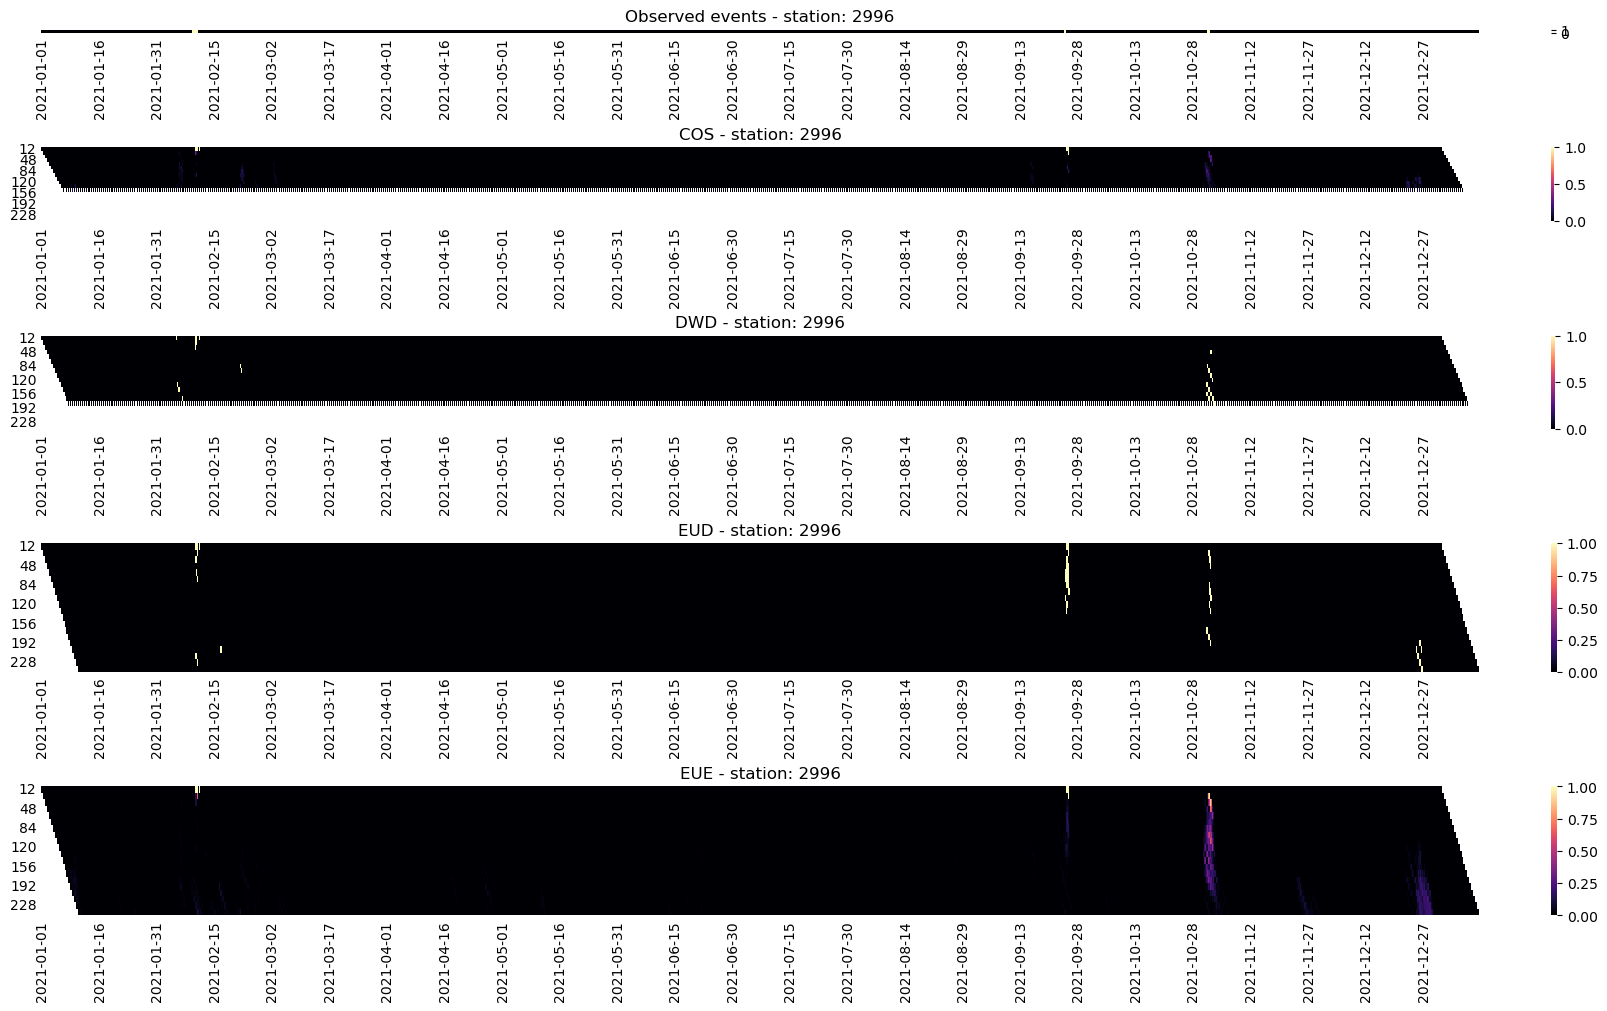

In [132]:
# plot the predicted probabilit for a station and NWP model
stn = 4359
stn = 2996

fig = plt.figure(constrained_layout=True, figsize=(16, 10))
leadtimes = [models[m]['leadtimes'] for m in models]
gs = fig.add_gridspec(nrows=5, height_ratios=[1] + leadtimes)

ax1 = fig.add_subplot(gs[0])
plot_DataArray(obs.sel(id=stn), ax=ax1,
        title=f'Observed events - station: {stn}')

for i, (m, lt) in enumerate(zip(models, leadtimes)):
    ax = fig.add_subplot(gs[i + 1], sharex=ax1)
    da = pred.sel(id=stn, model=m).isel(leadtime=slice(0, lt))
    plot_DataArray(da, ax=ax, title=f'{m} - station: {stn}')

#### 3.1.2 Skill

With the previous matrixes we can easily compute the Brier score as the mean square error of probability.

In [20]:
# squared error
se = (obs - pred)**2
# se = se.isel(leadtime=slice(0, min_leadtime)) # keep only the leadtime that is available for all models

# Brier skill of each model and station
brier = se.mean(['leadtime', 'datetime']) #.isel(leadtime=slice(0, min_leadtime))

##### All stations

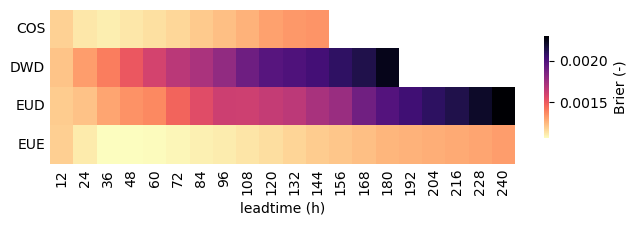

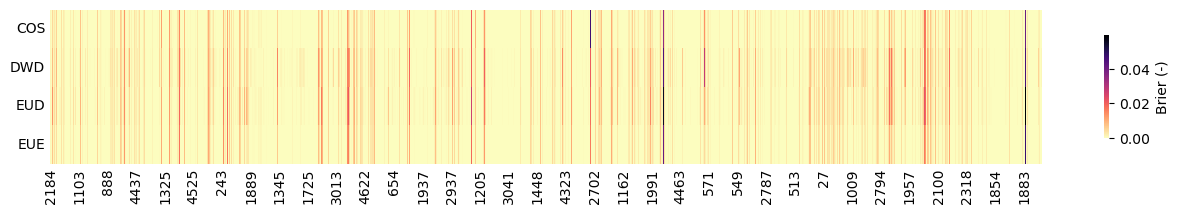

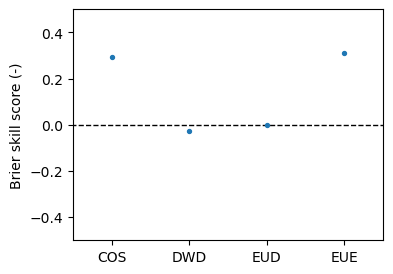

In [21]:
# plot Brier score according to model and forecast
plot_DataArray(se.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_DataArray(se.mean(['leadtime', 'datetime']).transpose(), yticklabels=se.model.data, ytick_step=1, xticklabels=se.id.data, xtick_step=30,
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.mean('id') / brier.sel(model='EUD').mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

The previous plot shows The Brier skill score using as a benchmark the ECMWF deterministic EUD. Positive values represent models better than the reference, whereas negative values represent models worse than the reference. As seen previously, the two probabilistic models have a higher skill than the reference, with ECMWF ensemble as the best forcing. The DWD is the worst of all the forcings. As expected, skill degrades with increasing leadtimes.

The second plot shows the Brier score by station and meteorological forcing. There are a lot of stations with Brier 0, but most of them represent stations with neither observed nor predicted events.

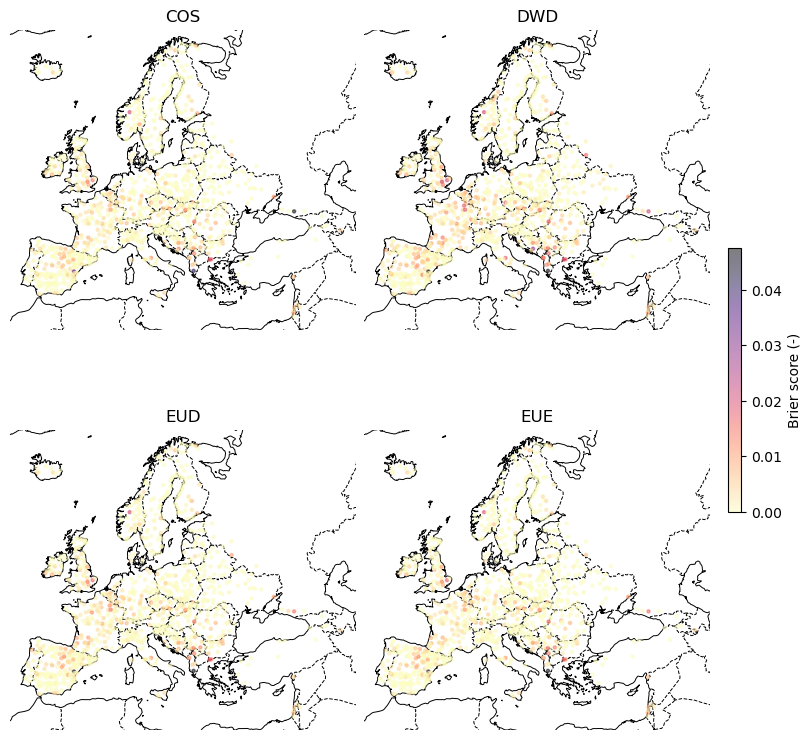

In [22]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

##### Stations with events

Here I will repeat the previous plots but removing stations without observed flood events. The objective is to check if these stations are masking the results.

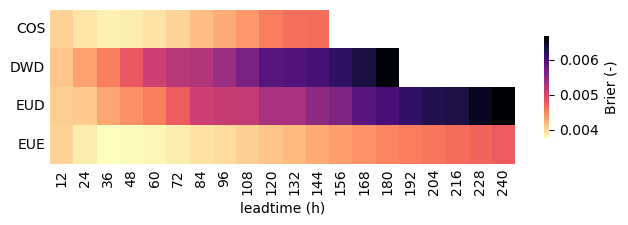

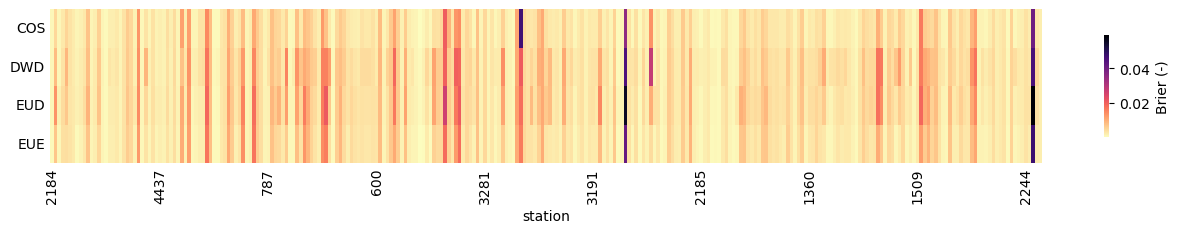

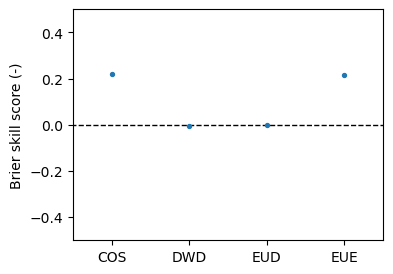

In [23]:
# select stations with events
se_ = se.sel(id=stations[mask_stn].index)

# plot Brier score according to model and forecast
plot_DataArray(se_.mean(['datetime', 'id']), xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
plot_DataArray(se_.mean(['leadtime', 'datetime']).transpose(), ytick_step=1, xtick_step=30, xlabel='station',
        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

# Brier skill score in terms of NWP model
BSS = 1 - brier.sel(id=stations[mask_stn].index).mean('id') / brier.sel(model='EUD', id=stations[mask_stn].index).mean('id')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

The results are very similar to those that take into account all the stations, not only those with observed flood events. The Brier values, though, are a bit lower.

These two previous plots show that the probabilistic forcings (COS and EUE) have a better Brier score than the deterministic forcings (DWD and EUE). Between the two deterministic forcings, EUD seems to have a larger leadtime skill (up to the 5th forecast).

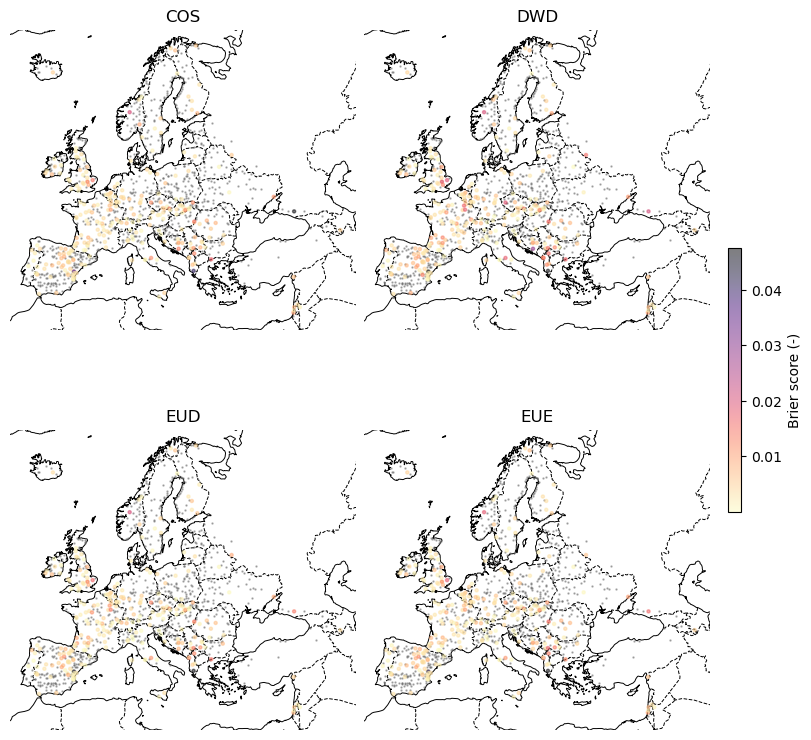

In [24]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, brier.sel(model=model).to_pandas(), mask=~mask_stn, ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_stations_with_events.jpg', bbox_inches='tight', dpi=300)

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if actual events where predicted at all, no matter leadtime.

To convert exceedance probability for each meteo forcing against events we need to come up with a total exceedance probability, i.e., combine the probabilities of each model into a single probability value. This total probability will later be compared against a probability threshold to discern events. I will test four different approaches:

* `current`:  the current notification criteria. At least a probabilistic and deterministic model must exceed the probability threshold.
* `model_mean`
* `member_weighted`
* `brier_weighted`

#### 3.2.1 Exceedance over probability threshold

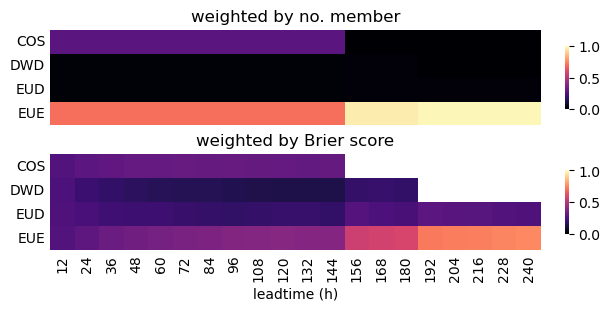

In [25]:
# exceedance according to current criteria
deterministic = (pred.sel(model=['EUD', 'DWD']) > probabilities).any('model')
probabilistic = (pred.sel(model=['EUE', 'COS']) > probabilities).any('model')
current = deterministic & probabilistic

# exceedance according to mean over models
model_mean = pred.mean('model', skipna=True) > probabilities

# exceedance according to the mean over models weighted by the number of members
weights_member = weights.isel(leadtime=slice(None, None, 2))
weights_member['leadtime'] = pred.leadtime
weights_member /= weights_member.sum('model')
member_weighted = pred.weighted(weights_member).mean('model', skipna=True) > probabilities

# exceedance according to the mean over models weighted by the inverse Brier score
brier = se.mean(['id', 'datetime'])
weights_brier = 1 / brier**2
weights_brier /= weights_brier.sum('model')
brier_weighted = pred.weighted(weights_brier.fillna(0)).mean('model', skipna=True) > probabilities

# merge all in a single DataArray
pred_reshape = xr.Dataset({'current': current,
                           'model_mean': model_mean,
                           'member_weighted': member_weighted,
                           'brier_weighted': brier_weighted}).to_array(dim='model')

# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    htm = plot_DataArray(da, vmin=0, vmax=1, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}', cbar_kws={'shrink': .66})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')

In [26]:
# exportar weights based on the Brier score
weights_brier.to_netcdf('results/weights_brier.nc')

To create a weight based on the Brier score I need to invert the values, since lower Brier score values represent better models. Therefore, I compute the inverse of the squared Brier score. To normalize weights (values between 0 and 1) I divide the previous weight matrix by its sum over models.

The previous plot shows the weighting factors for the mean weighted by the number of members of each model (top), and the mean weighted by the performace of the model measured in terms of Brier score (bottom). When taking into account the number of members, obviously COSMO-LEPS and EUE get the vast majority of the weight, rendering no importance to any of the deterministic models. Between the two probabilistic models, EUE prevails over COSMO-LEPS, even though we've seen that their performance is comparable. However, when weighting according to performance, COSMO-LEPS and EUE get a very similar value during the leadtime span for which COSMO-LEPS is available. The probabilistic models have lower weights, but not as insignificat as when weighting by the number of members. In this sense, this last weighting method is a mid ground point between the simple model mean and the mean weighted by the number of members.

**Graphical explanation of the procedure**

In [27]:
stn = n_events_obs.idxmax().data
stn = 119
#stn = 4359
stn = 2996
# stn = 2753
# stn = 2376
print('Station {0} has {1} observed events'.format(stn, n_events_obs.sel(id=stn).data))

Station 2996 has 3 observed events


Station 2996 has 5 predicted events


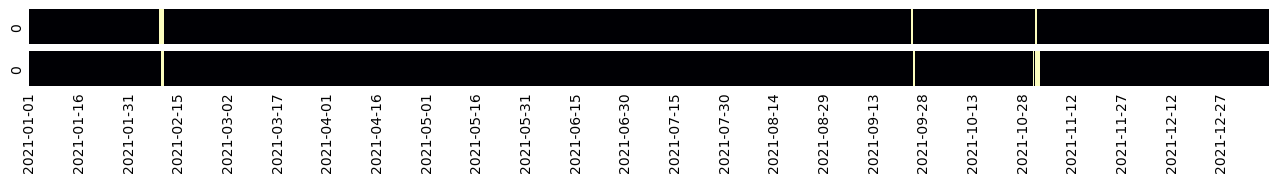

In [28]:
das = {'obs': obs.sel(id=stn), 
       'pred': pred_reshape.sel(id=stn, probability=.3, model='member_weighted').any('leadtime').astype(int)}

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data
print('Station {0} has {1} predicted events'.format(stn, n_events_pred))

fig, axes = plt.subplots(nrows=2, figsize=(16, 1), sharex=True, sharey=True)
for ax, (title, da) in zip(axes, das.items()):
    plot_DataArray(da, ax=ax, xtick_step=60, cbar=False)

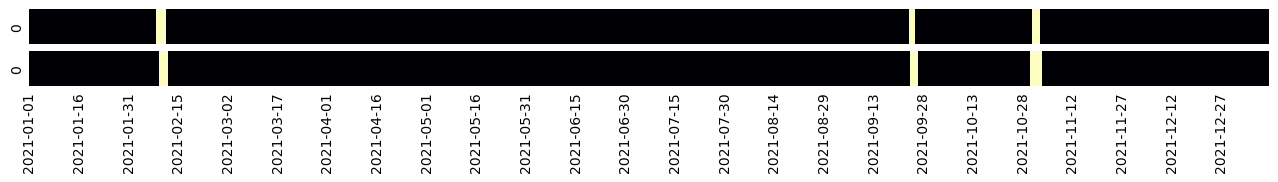

In [29]:
# rolling sum of observations and predictions
w = 7
mp = int(w / 2) + 1
das_w = {key: das[key].rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0 for key in das}

fig, axes = plt.subplots(nrows=2, figsize=(16, 1), sharex=True, sharey=True)
for ax, (title, da) in zip(axes, das_w.items()):
    plot_DataArray(da, ax=ax, xtick_step=60, cbar=False)

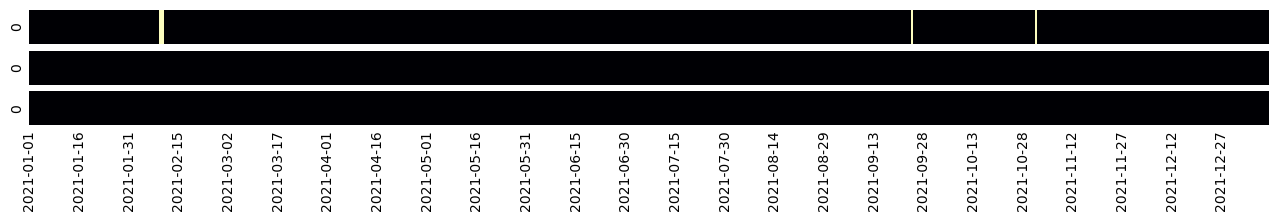

In [30]:
# compute true positives and false negatives
aux1 = das_w['pred'].where(das['obs'] == 1)
tp, fn = (aux1 == 1).astype(int), (aux1 == 0).astype(int)

# compute false positives
aux2 = das['pred'].where(das_w['obs'] == 0)
fp = (aux2 == 1).astype(int)

fig, axes = plt.subplots(nrows=3, figsize=(16, 1.5), sharex=True, sharey=True)
for ax, da in zip(axes, [tp, fn, fp]):
    plot_DataArray(da, ax=ax, xtick_step=60, cbar=False)

In [31]:
TP = (tp.isel(datetime=0) + (tp.diff('datetime') == 1)).sum('datetime')
TP = xr.ufuncs.minimum(TP, n_events_obs.sel(id=stn)).data
FN = n_events_obs.sel(id=stn).data - TP
FP = max(0, n_events_pred - TP)

TP, FN, FP

(array(3, dtype=int64), 0, 2)

In [32]:
TP / (TP + FN), TP / (TP + FP), 2 * TP / (2 * TP + FP + FN)

(1.0, 0.6, 0.75)

**Compute for all the stations**

In [33]:
# DataArrays of exceedance over threshold
das = {'obs': obs, 
       'pred': pred_reshape.any('leadtime').astype(int)} #.sel(probability=.3)

n_events_pred = (xr.concat([das['pred'].isel(datetime=[0]), das['pred'].diff('datetime')], dim='datetime') == 1).sum('datetime').data

# rolling sum of observations and predictions
w = 7
mp = int(w / 2) + 1
das_w = {key: das[key].rolling({'datetime': w}, center=True, min_periods=mp).sum() > 0 for key in das}

# compute true positives
tp = (das_w['pred'].where(das['obs']) == 1).astype(int)
tp = (tp.isel(datetime=0) + (tp.diff('datetime') == 1)).sum('datetime')
tp = xr.ufuncs.minimum(tp, n_events_obs)
# compute false negatives and false positives
fn = n_events_obs - tp
fp = xr.ufuncs.maximum(0, n_events_pred - tp)

# compute metrics
skill = xr.Dataset({'recall': tp / (tp + fn),
                   'precision': tp / (tp + fp),
                   'f1': 2 * tp / (2 * tp + fp + fn)})#.to_array(dim='metric')

**All the stations**

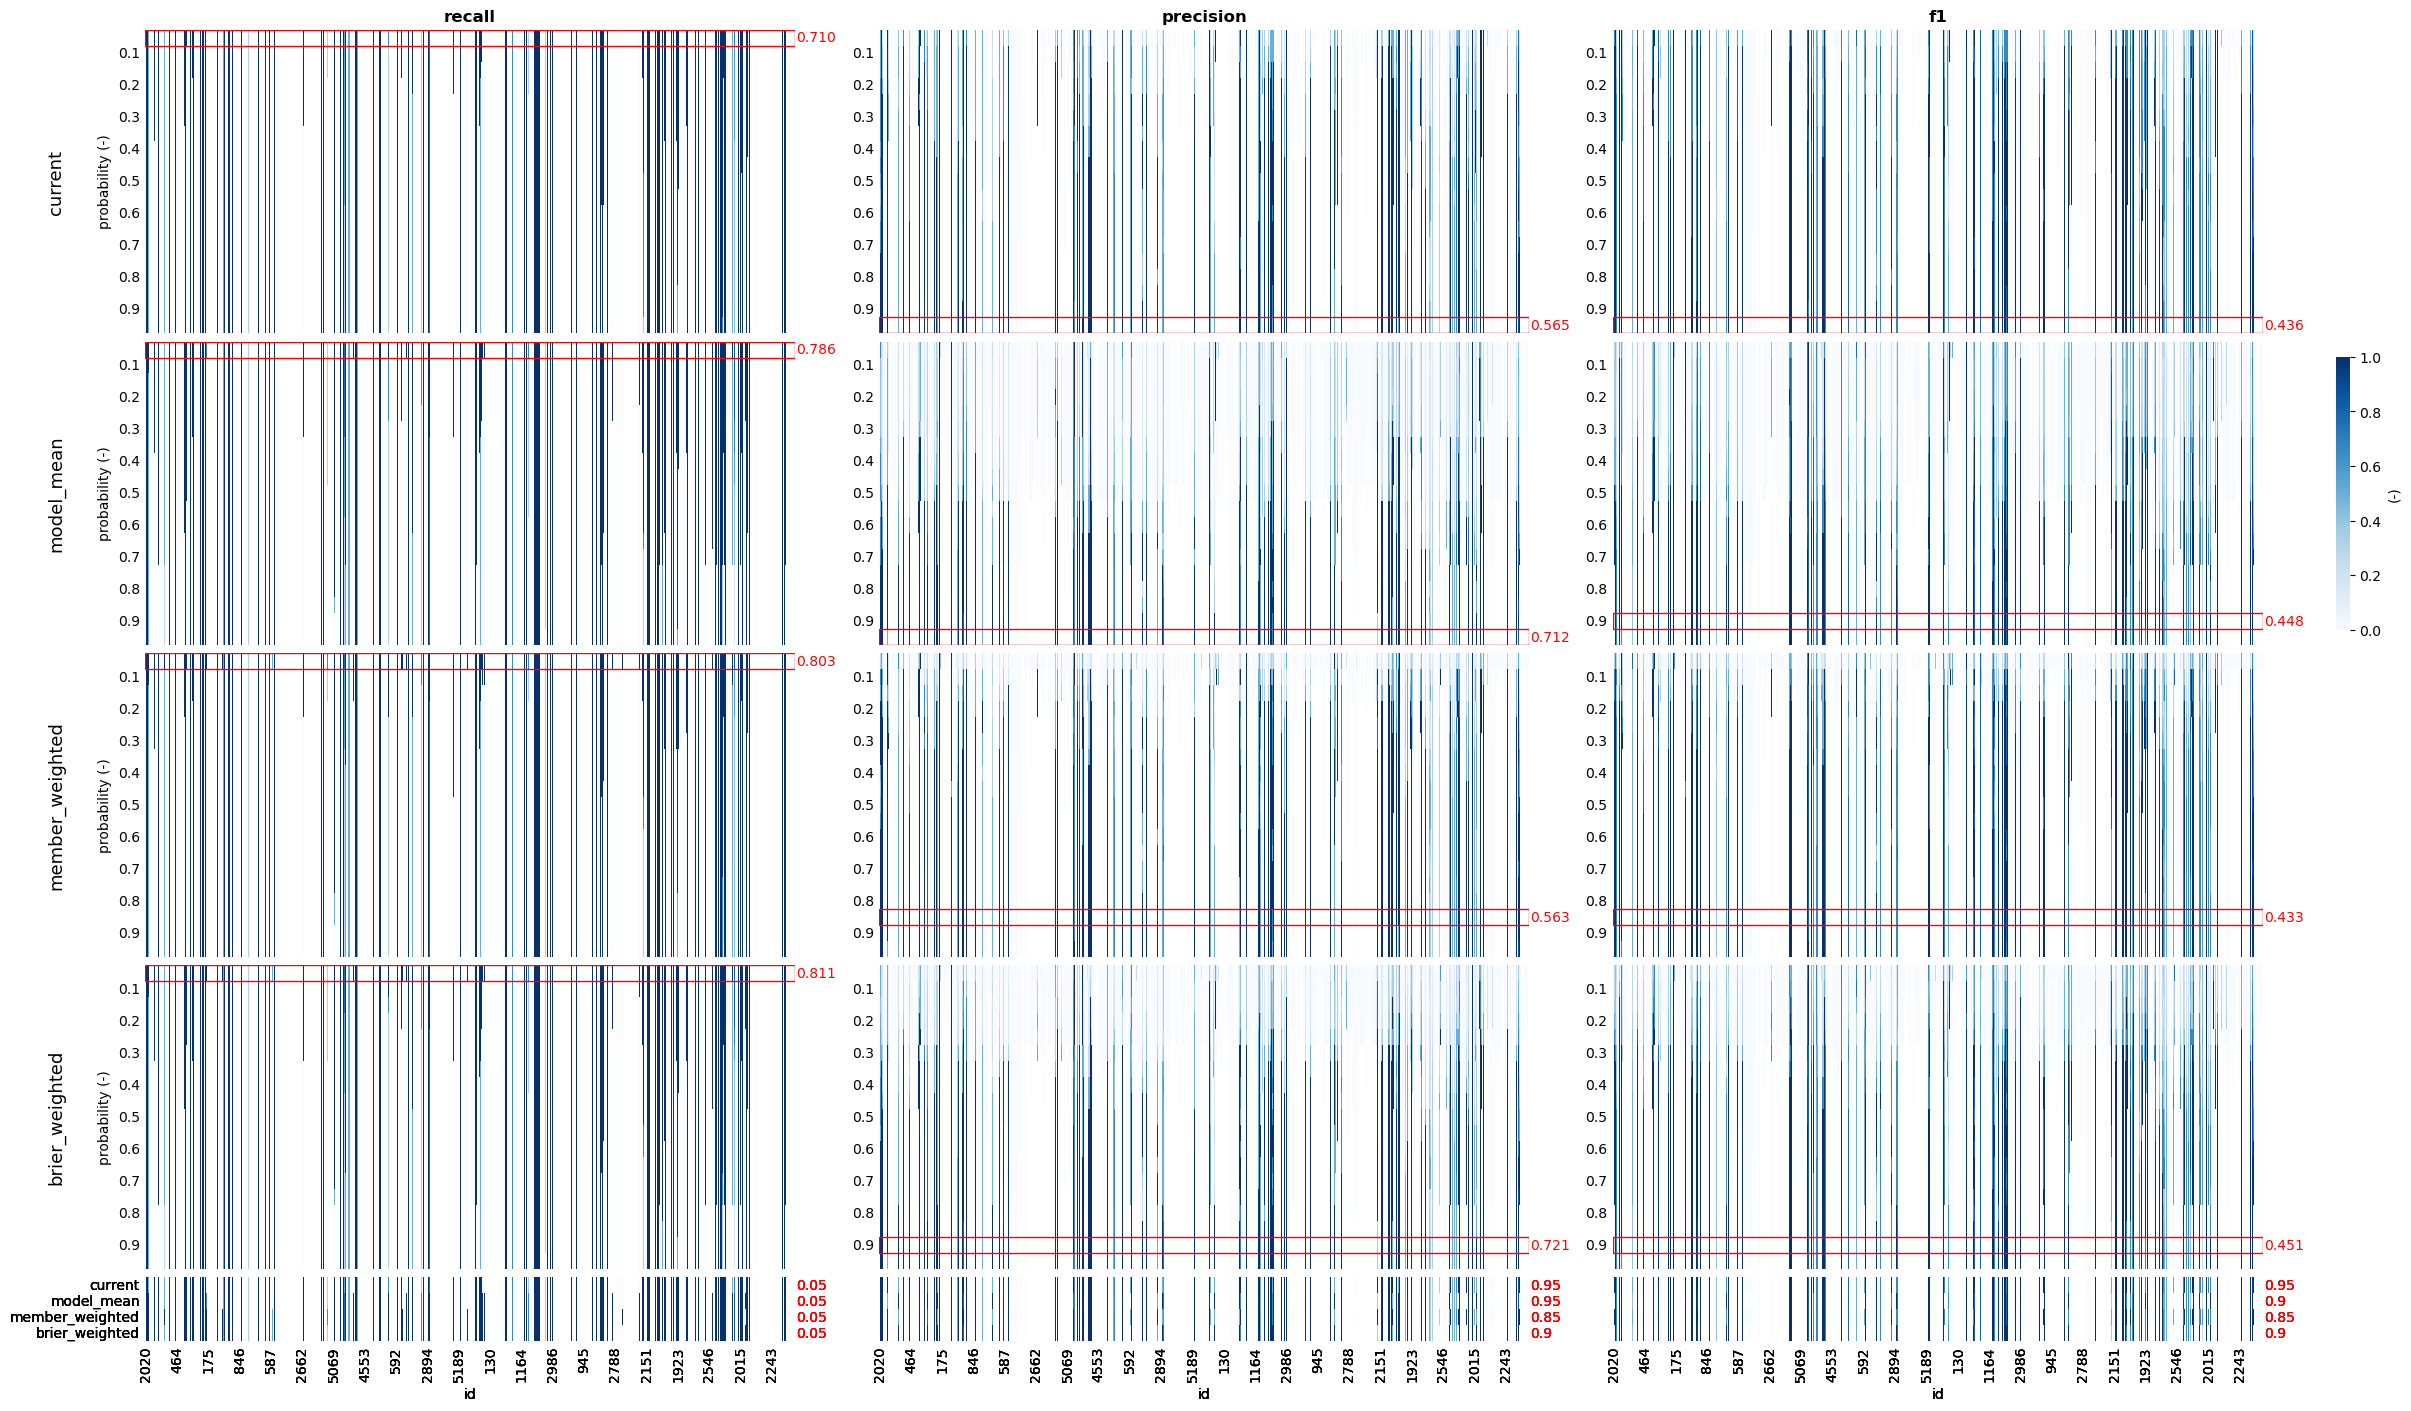

In [34]:
# plot performace for individual stations
filename = f'{path_out}eventwise_station_skill_(all_stations).jpg'
plot_skill(skill, xtick_step=50, save=filename, figsize=(24, 14))

* Most of the stations are in white, which means that they didn't have neither observed nor forecasted events. This specifically noticeable in the recall.
* Lower probability threshols optimize recall.
* Higher probability thresholds optimize precision.
* Even f1 is the harmonic mean of recall and precision, its peak values are also for high probability thresholds. The highest value of all is obtained by the `brier_weighted` method and the 90% probability.

CURRENT
-------
Best probability thresholds
recall:		0.050
precision:	0.950
f1:		0.950

MODEL MEAN
----------
Best probability thresholds
recall:		0.050
precision:	0.950
f1:		0.900

MEMBER WEIGHTED
---------------
Best probability thresholds
recall:		0.050
precision:	0.850
f1:		0.850

BRIER WEIGHTED
--------------
Best probability thresholds
recall:		0.050
precision:	0.900
f1:		0.900



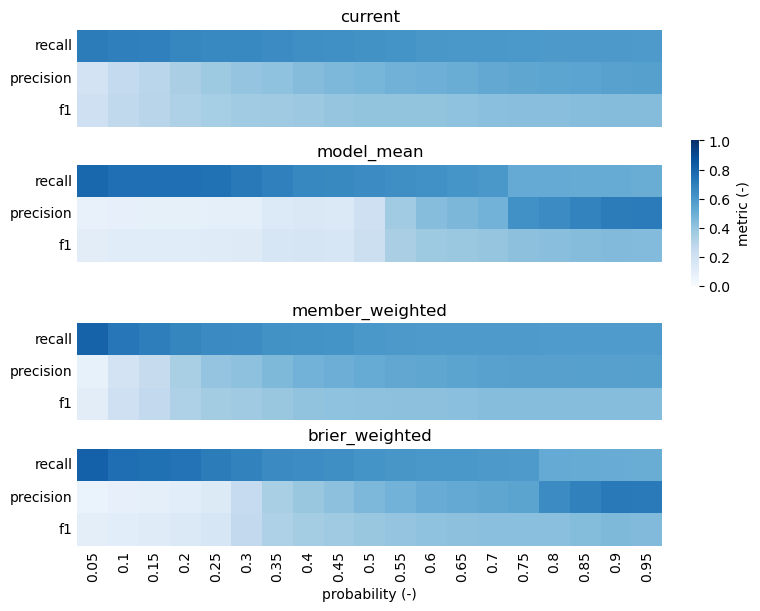

In [35]:
# plot average performance over stations
fig, axes = plt.subplots(nrows=len(skill.model), figsize=(7.5, 6), constrained_layout=True, sharex=True, sharey=True)
for i, (ax, model) in enumerate(zip(axes, skill.model.data)):
    da = skill.sel(model=model).mean('id').to_array(dim='metric')
    if i == 1:
        cbar = True
    else:
        cbar = False
    plot_DataArray(da, xtick_step=1, ytick_step=1, cmap='Blues', ax=ax, vmin=0, vmax=1, cbar=cbar, title=model,
            cbar_kws={'shrink': 1.5, 'label': 'metric (-)'})
    if i == len(skill.model) - 1:
        ax.set_xlabel('probability (-)')
        
    print(model.upper().replace('_', ' '))
    print('-' * len(model))
    print('Best probability thresholds\n{0}:\t\t{3:.3f}\n{1}:\t{4:.3f}\n{2}:\t\t{5:.3f}\n'.format(*da.metric.data, *da.idxmax('probability').data))
    
plt.savefig(f'{path_out}eventwise_average_skill_(all_stations).jpg', bbox_inches='tight', dpi=300)

> <font color='red'>Improve this figure to show the best performing option for each model and metric.</font>

The previous plot summarizes performance over stations. The general look of all models is similar, but there are slight differences:

* `model_mean` and `brier_weighted` are very similar, with slightly higher values for `brier_weighted`. Their main difference compared with the other two models is a marked higher precision at larger probability thresholds.
* `current` and `member_weighted` look very alike, with slightly higher performance for the latter.

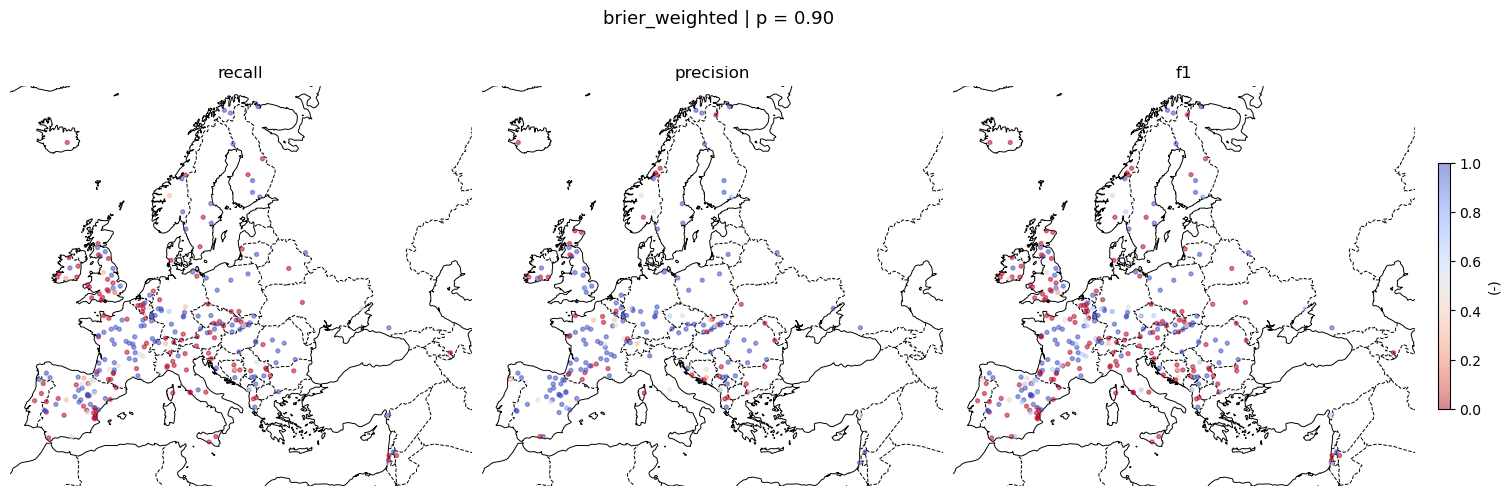

In [36]:
# find probability threshold that optimizes f1 for a given model
metric = 'f1'
model = 'brier_weighted'
best_p = skill[metric].sel(model=model).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(model=model, probability=best_p).to_pandas()
    # plot a map of the Brier score for the COS model
    plot_map_stations(stations.X, stations.Y, metric_id, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{model} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

plt.savefig(f'{path_out}eventwise_skill_map_(all_stations).jpg', bbox_inches='tight', dpi=300)

Surprisingly, there's a larger amount of stations with poor recall (red dots in the left panel) than precision (red dots in the central panel). This means that there is a stronger tendency towards missing events than towards mistakenly producing events.

A priori, there's no clear pattern in the geographical location of high or poor performing stations.

**Stations with events**

Let's repeat the previous plots but taking into account only stations with observed flood events.

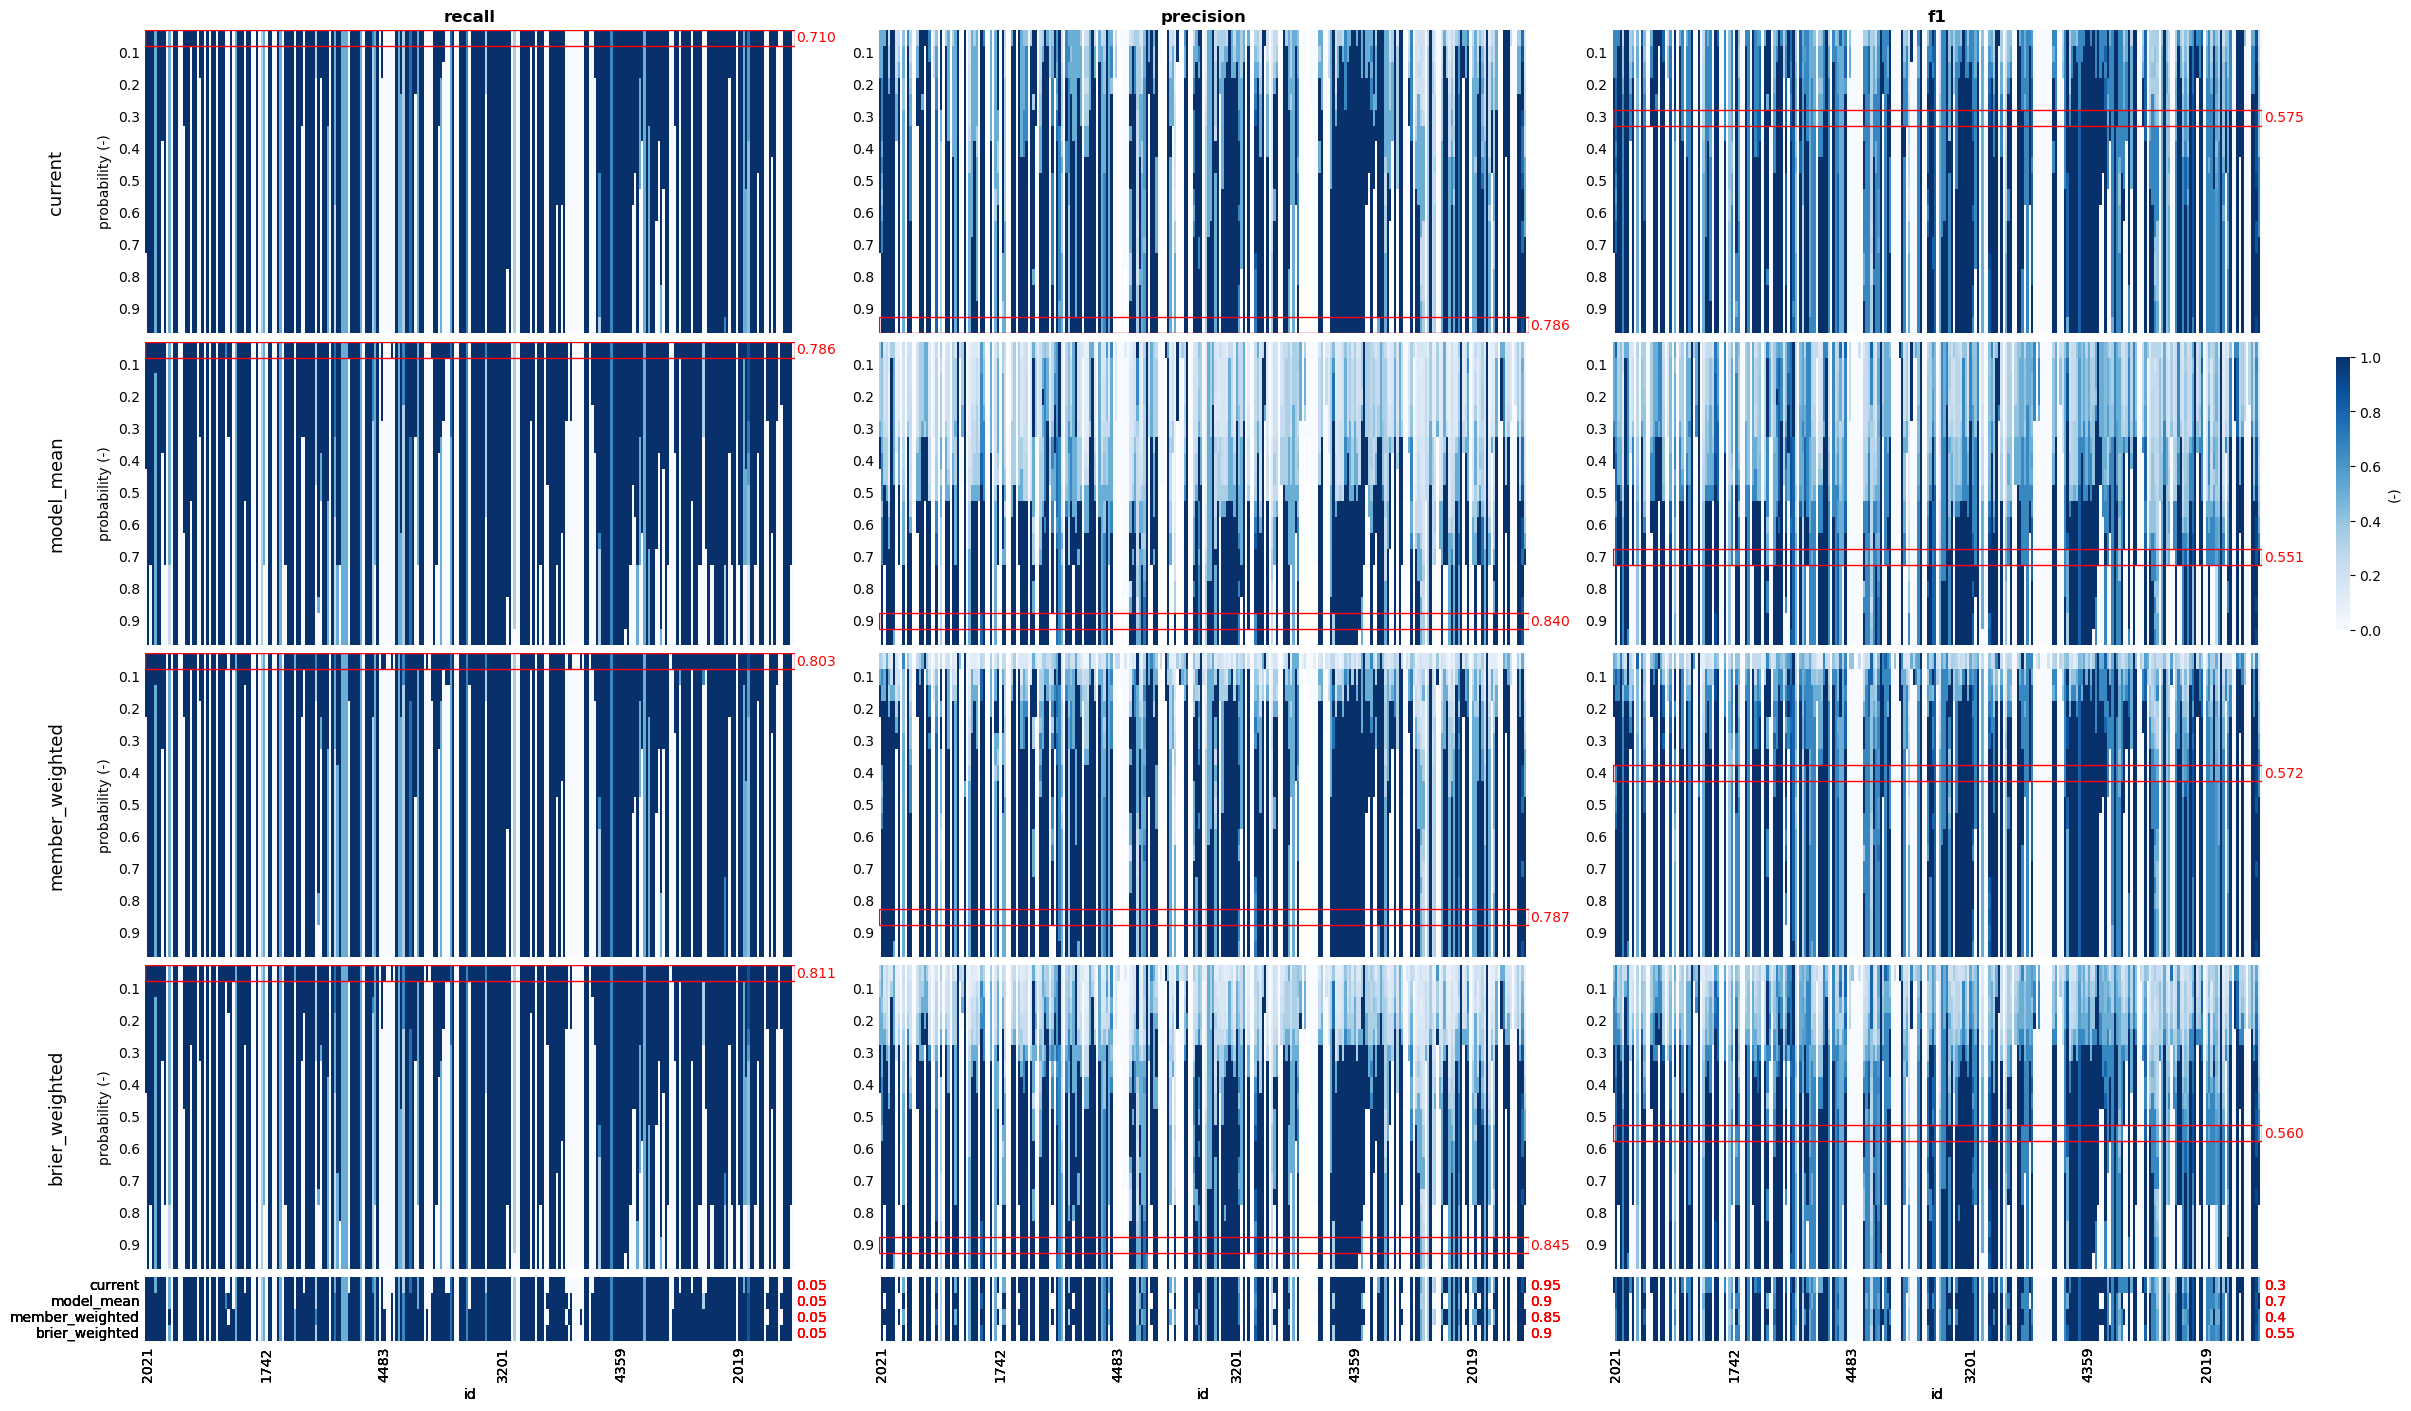

In [37]:
# plot performace for individual stations
stns = stations[mask_stn].index
filename = f'{path_out}eventwise_station_skill_(stations_with_events).jpg'
plot_skill(skill.sel(id=stns), xtick_step=50, save=filename, figsize=(24, 14))

Compared with the similar plot with all stations, there is barely no white in this one, where white means stations with neither observed nor predicted events.

* Recall values seem higher in general (larger areas dark blue). Lower probability thresholds optimize recall.
* As seen before, recall improves with larger probability thresholds. Specifically for the methods `model_mean` and `brier_weighted`, there is clear threshold above which some stations show high precision.
* The highest f1 score is obtained by the `current` model at 30% probability, which is the actual curren probability threshold.

CURRENT
-------
Best probability thresholds
recall:		0.050
precision:	0.950
f1:		0.300

MODEL MEAN
----------
Best probability thresholds
recall:		0.050
precision:	0.900
f1:		0.700

MEMBER WEIGHTED
---------------
Best probability thresholds
recall:		0.050
precision:	0.850
f1:		0.400

BRIER WEIGHTED
--------------
Best probability thresholds
recall:		0.050
precision:	0.900
f1:		0.550



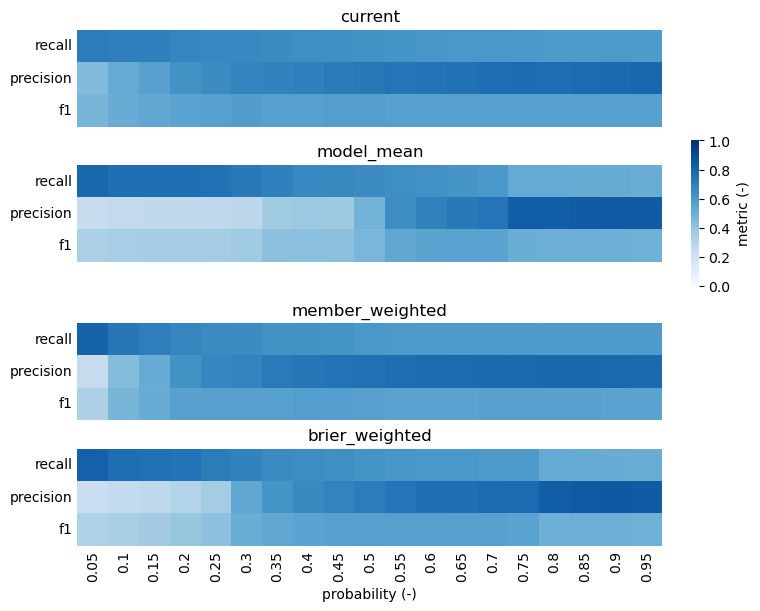

In [38]:
# plot average performance over stations
stn = stations[mask_stn].index
fig, axes = plt.subplots(nrows=len(skill.model), figsize=(7.5, 6), constrained_layout=True, sharex=True, sharey=True)
for i, (ax, model) in enumerate(zip(axes, skill.model.data)):
    da = skill.sel(model=model, id=stn).mean('id').to_array(dim='metric')
    if i == 1:
        cbar = True
    else:
        cbar = False
    plot_DataArray(da, xtick_step=1, ytick_step=1, cmap='Blues', ax=ax, vmin=0, vmax=1, cbar=cbar, title=model,
            cbar_kws={'shrink': 1.5, 'label': 'metric (-)'})
    if i == len(skill.model) - 1:
        ax.set_xlabel('probability (-)')
        
    print(model.upper().replace('_', ' '))
    print('-' * len(model))
    print('Best probability thresholds\n{0}:\t\t{3:.3f}\n{1}:\t{4:.3f}\n{2}:\t\t{5:.3f}\n'.format(*da.metric.data, *da.idxmax('probability').data))
    
plt.savefig(f'{path_out}eventwise_average_skill_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

The conclusions are very similar to those commented on the similar plot with all stations. However, performace is higher in general.

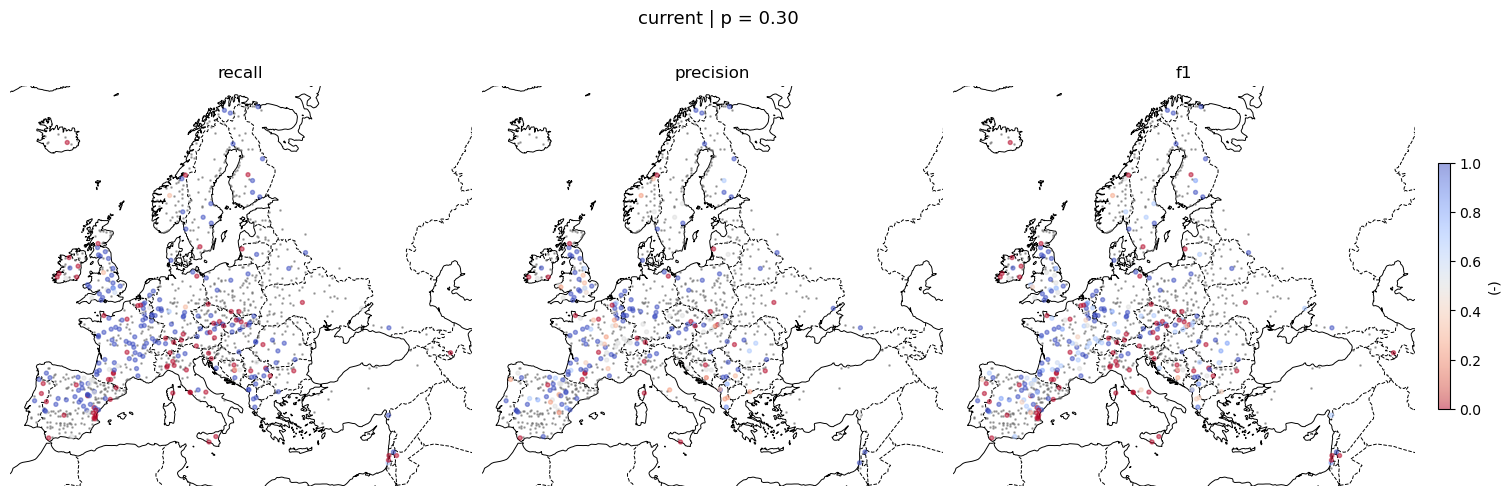

In [39]:
# find probability threshold that optimizes f1 for a given model
metric = 'f1'
model = 'current'
stn = stations[mask_stn].index
best_p = skill[metric].sel(model=model, id=stn).mean('id').idxmax(dim='probability', skipna=True)

# plot a map of the metrics
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, metric in zip(axes, list(skill)):
    # extract metric values for stations
    metric_id = skill[metric].sel(model=model, probability=best_p).to_pandas()
    # plot a map of the Brier score for the COS model
    plot_map_stations(stations.X, stations.Y, metric_id, mask=~mask_stn, ax=ax,
                      rivers=None, size=8, cmap='coolwarm_r', title=metric)
fig.text(.475, 1.025, f'{model} | p = {best_p.data:.2f}', horizontalalignment='center', fontsize=13)
fig.colorbar(plot_map_stations.colorbar, shrink=.5, label=f'(-)');

plt.savefig(f'{path_out}eventwise_skill_map_(stations_with_events).jpg', bbox_inches='tight', dpi=300)

As explained before, there are more stations with poor recall than precision.

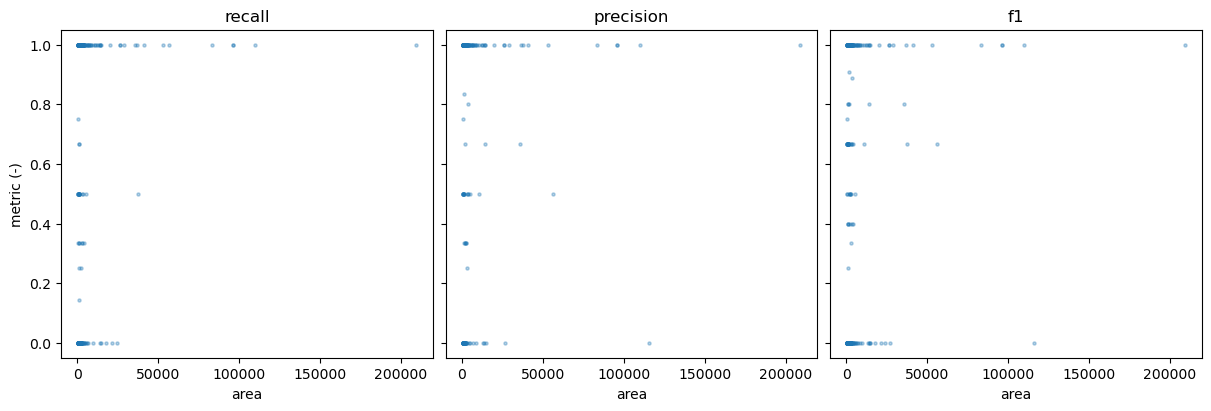

In [66]:
metric = 'f1'
attr = 'area'

model = 'brier_weighted'
p = .9

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)

for i, (ax, metric) in enumerate(zip(axes, list(skill))):
    ax.scatter(stations[attr], skill.sel(model=model, probability=p)[metric].to_pandas(), s=5, alpha=.33)
    ax.set_title(metric)
    ax.set_xlabel(attr)
    if i == 0:
        ax.set_ylabel('metric (-)')

In [77]:
def plot_skill_vs_attribute(skill, model, probability, attribute, id=None, **kwargs):
    """
    """
    
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)
    
    if id is None:
        ds = skill.sel(model=model, probability=probability)
        x = attribute
    else:
        ds = skill.sel(id=id, model=model, probability=probability)
        x = attribute.loc[id]
    for i, (ax, metric) in enumerate(zip(axes, list(ds))):
        ax.scatter(x, ds[metric].to_pandas(), s=5, alpha=.33)
        ax.set_title(metric)
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'])
        if i == 0:
            ax.set_ylabel('metric (-)')

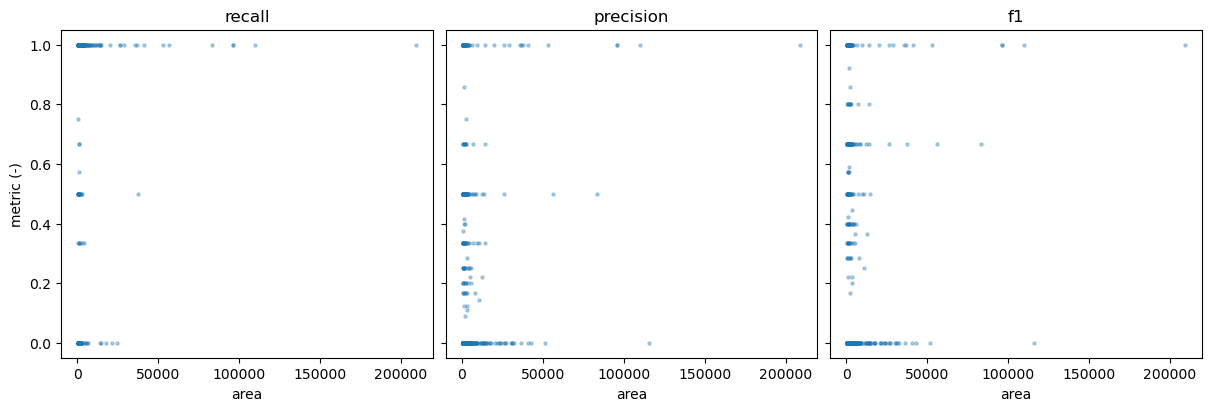

In [79]:
attr = 'area'
plot_skill_vs_attribute(skill, 'brier_weighted', .3, stations[attr], xlabel=attr)

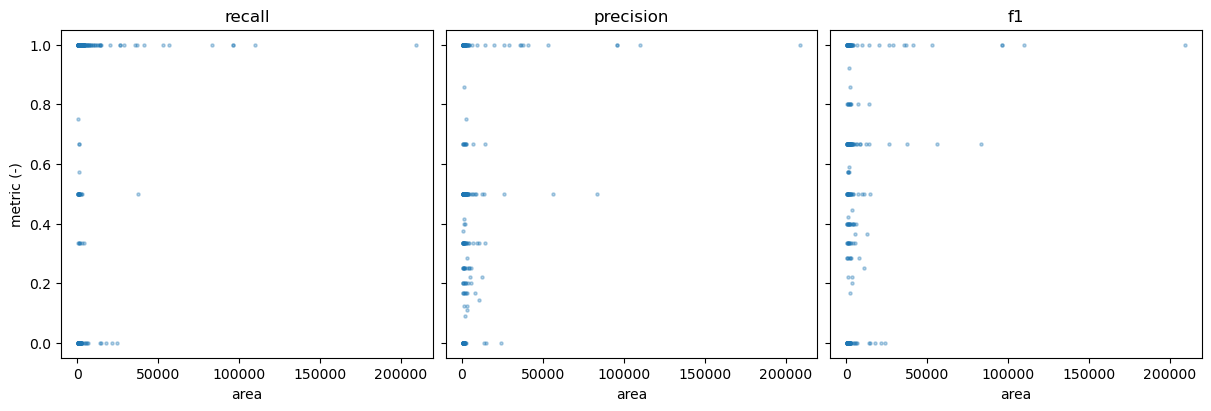

In [80]:
attr = 'area'
plot_skill_vs_attribute(skill, 'brier_weighted', .3, stations[attr], id=stn, xlabel=attr)